# Neural Network - Similiarity Function

This notebook details the process of choosing the similarity function that determines the images that are similar to a given image.
The implementation of the network is based on the Siamese network implementation. This class of networks is known to be more robust to class imbalance, so it fits the data on which we train.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm

In [65]:
# load the data
base_path = 'active_learning_labels/'
full_data_paths = pd.read_csv(base_path + 'round_0.csv')

current_round = 1

if current_round > 0:
    for i in range(1, current_round):
        path = base_path + 'round_' + str(i) + '.csv'
        data = pd.read_csv(path)
        full_data_paths = pd.concat([full_data_paths, data], ignore_index=True)

data_paths = full_data_paths[['image1_path', 'image2_path', 'similarity']]

print(data_paths.head())

                                         image1_path  \
0  (datasets/house_styles/all_images/001_d2c7428a...   
1  (datasets/house_styles/all_images/453_d7b5d246...   
2  (datasets/house_styles/all_images/116_32f01ef6...   
3  (datasets/house_styles/all_images/301_b73b9663...   
4  (datasets/house_styles/all_images/042_06b56791...   

                                         image2_path  similarity  
0  (datasets/house_styles/all_images/366_08eff319...         3.0  
1  (datasets/house_styles/all_images/122_e44a0cb3...         0.0  
2  (datasets/house_styles/all_images/174_55a7b3f9...         0.0  
3  (datasets/house_styles/all_images/116_32f01ef6...         0.0  
4  (datasets/house_styles/all_images/069_d3bedc1f...         1.0  


In [17]:
# split the data into training and testing
train_data = data_paths.sample(frac=0.8, random_state=42)
eval_data = data_paths.drop(train_data.index)

print("Train: ", train_data.shape, "Eval: ", eval_data.shape)

Train:  (120, 3) Test:  (30, 3)


In [23]:
class ImageSimilarityDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        self.master_path = ''

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load images from the paths
        image1_path = self.master_path + self.data.iloc[idx, 0].strip("()")
        image2_path = self.master_path + self.data.iloc[idx, 1].strip("()")
        
        # Load images
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        
        # Apply transforms if provided
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        # Get similarity score
        similarity = self.data.iloc[idx, 2]
        label = 0 if similarity < 2 else 1
        
        return image1_path, image2_path, image1, image2, torch.tensor(label, dtype=torch.float32)

# Define transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224 (standard for many models)
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])


In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device('cpu')

print(device)

cpu


In [20]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        
        # Adaptive pooling layer to ensure the output size is consistent
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # Adjust pooling size to handle dynamic input
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),  # Input size adjusted for adaptive pooling
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 2)
        )
        
    def forward_once(self, x):
        # Forward pass 
        x = self.cnn1(x)
        x = self.adaptive_pool(x)  # Adaptive pooling to standardize the feature map size
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        # Forward pass of input 1
        output1 = self.forward_once(input1)
        # Forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

# class SiameseNetwork(nn.Module):
    
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         # Setting up the Sequential of CNN Layers
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=1),  # Adjusted for RGB input
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
            
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),

#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),
#         )
        
#         # Adaptive pooling layer to ensure the output size is consistent
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # Adjust pooling size to handle dynamic input
        
#         # Defining the fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(256 * 6 * 6, 1024),  # Input size adjusted for adaptive pooling
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
            
#             nn.Linear(1024, 128),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(128, 2)
#         )
        
#     def forward_once(self, x):
#         # Forward pass 
#         x = self.cnn1(x)
#         x = self.adaptive_pool(x)  # Adaptive pooling to standardize the feature map size
#         x = x.view(x.size(0), -1)  # Flatten the feature map
    #     x = self.fc1(x)
    #     return x

    # def forward(self, input1, input2):
    #     # Forward pass of input 1
    #     output1 = self.forward_once(input1)
    #     # Forward pass of input 2
    #     output2 = self.forward_once(input2)
    #     return output1, output2


In [24]:
class SmallSiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SmallSiameseNetwork, self).__init__()
        # Setting up a smaller CNN
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=1),  # Fewer filters, smaller kernel size
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # Max pooling with smaller stride to reduce spatial dimensions
            nn.Dropout2d(p=0.2),  # Reduced dropout rate
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  # Fewer filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # Smaller max-pooling
            nn.Dropout2d(p=0.2),

            # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Fewer filters
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2, stride=2),
            # nn.Dropout2d(p=0.2),
        )
        
        # Adaptive pooling layer to standardize output size (reduce to 3x3)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))  # Smaller output size (3x3)
        
        # Defining smaller fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),  # Reduced size based on new feature map size
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),  # Keep some dropout for regularization
            
            nn.Linear(128, 64),  # Smaller fully connected layer
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 2)  # Output layer remains the same
        )
        
    def forward_once(self, x):
        # Forward pass 
        x = self.cnn1(x)
        x = self.adaptive_pool(x)  # Adaptive pooling to standardize the feature map size
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        # Forward pass of input 1
        output1 = self.forward_once(input1)
        # Forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [25]:
# define the loss function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        ### Binary:
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)

        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        
        return loss

In [33]:
def train_siamese_network(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (img1_path, img2_path, img1, img2, labels) in enumerate(train_loader):
            # Move tensors to the appropriate device
            # img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Print statistics
            if (i + 1) % 5 == 0:  # Print every 5 batches
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

    return model

In [34]:
siamese_net = SmallSiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.01, weight_decay=0.0005)

# Create datasets
train_dataset = ImageSimilarityDataset(train_data, transform=transform)
eval_dataset = ImageSimilarityDataset(eval_data, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Train the model
num_epochs = 100

trained_model = train_siamese_network(siamese_net, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Step [5/15], Loss: 0.1588
Epoch [1/10], Step [10/15], Loss: 0.0906
Epoch [1/10], Step [15/15], Loss: 0.1079
Epoch [2/10], Step [5/15], Loss: 0.0731
Epoch [2/10], Step [10/15], Loss: 0.0686
Epoch [2/10], Step [15/15], Loss: 0.0999
Epoch [3/10], Step [5/15], Loss: 0.0832
Epoch [3/10], Step [10/15], Loss: 0.0772
Epoch [3/10], Step [15/15], Loss: 0.0897
Epoch [4/10], Step [5/15], Loss: 0.0817
Epoch [4/10], Step [10/15], Loss: 0.0771
Epoch [4/10], Step [15/15], Loss: 0.0758
Epoch [5/10], Step [5/15], Loss: 0.1165
Epoch [5/10], Step [10/15], Loss: 0.0861
Epoch [5/10], Step [15/15], Loss: 0.0729
Epoch [6/10], Step [5/15], Loss: 0.0583
Epoch [6/10], Step [10/15], Loss: 0.0907
Epoch [6/10], Step [15/15], Loss: 0.0688
Epoch [7/10], Step [5/15], Loss: 0.0823
Epoch [7/10], Step [10/15], Loss: 0.0751
Epoch [7/10], Step [15/15], Loss: 0.0464
Epoch [8/10], Step [5/15], Loss: 0.0712
Epoch [8/10], Step [10/15], Loss: 0.0755
Epoch [8/10], Step [15/15], Loss: 0.0645
Epoch [9/10], Step [5/15

Test Accuracy: 0.2333


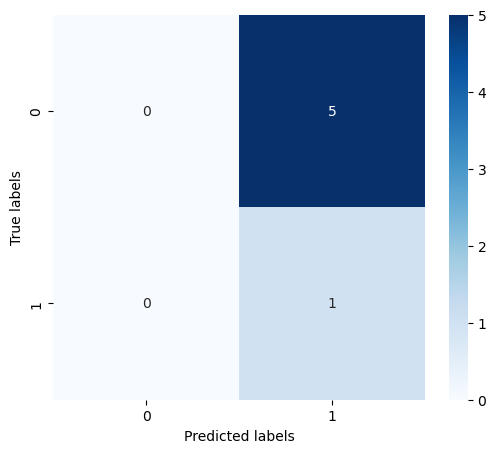

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_siamese_network(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for img1_path, img2_path, img1, img2, labels in test_loader:
            # Move tensors to the appropriate device
            # img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            output1, output2 = model(img1, img2)

            # Calculate the euclidean distance between the outputs
            dist = F.pairwise_distance(output1, output2)

            # Get predictions
            predicted = (dist < 1.0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # confusion matrix:
    matrix = confusion_matrix(labels, predicted)
    # plot:
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

test_siamese_network(trained_model, test_loader)

In [ ]:
# random_test = eval_data.sample(1)
# img1, img2, label = random_test.iloc[0]
# img1 = img1.strip("()")
# img2 = img2.strip("()")

# # Load images
# image1 = Image.open(img1).convert("RGB")
# image2 = Image.open(img2).convert("RGB")

# # Print Images
# display(image1)
# display(image2)

# # Apply transformations
# image1 = transform(image1).unsqueeze(0)
# image2 = transform(image2).unsqueeze(0)

# # Forward pass
# output1, output2 = trained_model(image1, image2)

# # Calculate the euclidean distance between the outputs
# # diff = output1 - output2
# # dist_sq = torch.sum(torch.pow(diff, 2), 1)
# # dist = torch.sqrt(dist_sq)
# dist = F.pairwise_distance(output1, output2)
# print(f"Distance: {dist.item()}")

# # Get predictions
# predicted = (dist < 1.0).float()
# true_label = 0 if label < 2 else 1

# print(f"Predicted: {predicted.item()}, Actual: {true_label}")

In [ ]:
# pca of the output:
from sklearn.decomposition import PCA

# Get the output of the model
outputs = []
labels = []

with torch.no_grad():
    for img1, img2, label in eval_loader:
        output1, output2 = trained_model(img1, img2)
        outputs.append(output1)
        labels.append(label)

outputs = torch.cat(outputs, dim=0)
labels = torch.cat(labels, dim=0)

# Perform PCA
pca = PCA(n_components=2)
pca_outputs = pca.fit_transform(outputs)

# Plot the PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_outputs[:, 0], y=pca_outputs[:, 1], hue=labels, palette='viridis')
plt.title('PCA of the Siamese Network Output')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# torch.save(model.state_dict(), "model.pt")
# print("Model Saved Successfully") 

In [ ]:
unlabeled_rows = full_data_paths[full_data_paths['similarity'].isna()].sample(5000)
unlabeled_rows = unlabeled_rows[['image1_path', 'image2_path', 'similarity']]
unlabeled_dataset = ImageSimilarityDataset(unlabeled_rows, transform=transform)
data_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False)

def active_learning_confident_samples(model, dataloader, margin=1.0, budget=100):
    """
    Identify the least confident samples from the model.
    
    Args:
        model: Trained Siamese network.
        dataloader: DataLoader for the dataset you want to evaluate.
        margin: The margin used in the contrastive loss.
        top_k: Number of least confident samples to return.
    
    Returns:
        A list of the top_k least confident samples (input pairs and distances).
    """
    model.eval()  # Set model to evaluation mode
    least_confident_samples = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for img1_path, img2_path, img1, img2, labels in tqdm(dataloader):
            # Get the model outputs for both images
            output1, output2 = model(img1, img2)
            
            # Calculate pairwise distance
            distances = F.pairwise_distance(output1, output2)
            
            # Calculate confidence score (distance from the margin)
            confidence_scores = torch.abs(distances - margin)

            # Collect the least confident samples (small confidence score means high uncertainty)
            for i in range(len(confidence_scores)):
                least_confident_samples.append((img1_path[i], img2_path[i], distances[i].item(), confidence_scores[i].item()))

    # Sort samples by confidence score (ascending, to get least confident samples)
    least_confident_samples.sort(key=lambda x: x[3])

    # Return the top_k least confident samples
    return least_confident_samples[:budget]

least_confident_samples = active_learning_confident_samples(trained_model, data_loader, margin=1.0, budget=100)
print(least_confident_samples)


In [ ]:
# TODO: from confidence samples save into a csv